# **CSE 546: Final Project**

## Libraries Importation and Data Reading
- Import the necessary libraries.
- Load and inspect the movie reviews dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    train_test_split,
    GridSearchCV,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    make_scorer,
)
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    SelectFromModel,
    VarianceThreshold,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_samples
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, ward, linkage
from sklearn.metrics import silhouette_samples
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
df1 = pd.read_csv("Data.csv")
df2 = pd.read_csv("extra_hard_samples.csv")
ds = pd.concat([df1, df2], axis=0).reset_index(drop=True)

y = ds["class"]
images = ds["image_name"]
ds = ds.drop("class", axis=1)
ds = ds.drop("image_name", axis=1)
X=ds.to_numpy()
y=y.to_numpy()

## KNN Classifier

### Base Algorithm

Fitting 4 folds for each of 24 candidates, totalling 96 fits


/Users/anujpatel/Coding/Python/CSE 546/MachineLearningFinalProject-1/finalproject/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[CV 1/4] END knn__n_neighbors=1; accuracy: (test=0.869) f1_score: (test=0.869) roc_auc: (test=0.920) total time=   0.1s
[CV 2/4] END knn__n_neighbors=1; accuracy: (test=0.870) f1_score: (test=0.870) roc_auc: (test=0.918) total time=   0.2s
[CV 1/4] END knn__n_neighbors=4; accuracy: (test=0.893) f1_score: (test=0.893) roc_auc: (test=0.967) total time=   0.1s
[CV 3/4] END knn__n_neighbors=1; accuracy: (test=0.857) f1_score: (test=0.857) roc_auc: (test=0.911) total time=   0.1s
[CV 4/4] END knn__n_neighbors=2; accuracy: (test=0.871) f1_score: (test=0.872) roc_auc: (test=0.945) total time=   0.1s
[CV 2/4] END knn__n_neighbors=2; accuracy: (test=0.868) f1_score: (test=0.869) roc_auc: (test=0.950) total time=   0.1s
[CV 3/4] END knn__n_neighbors=4; accuracy: (test=0.895) f1_score: (test=0.895) roc_auc: (test=0.966) total time=   0.1s
[CV 4/4] END knn__n_neighbors=4; accuracy: (test=0.889) f1_score: (test=0.889) roc_auc: (test=0.962) total time=   0.1s
[CV 2/4] END knn__n_neighbors=4; accurac

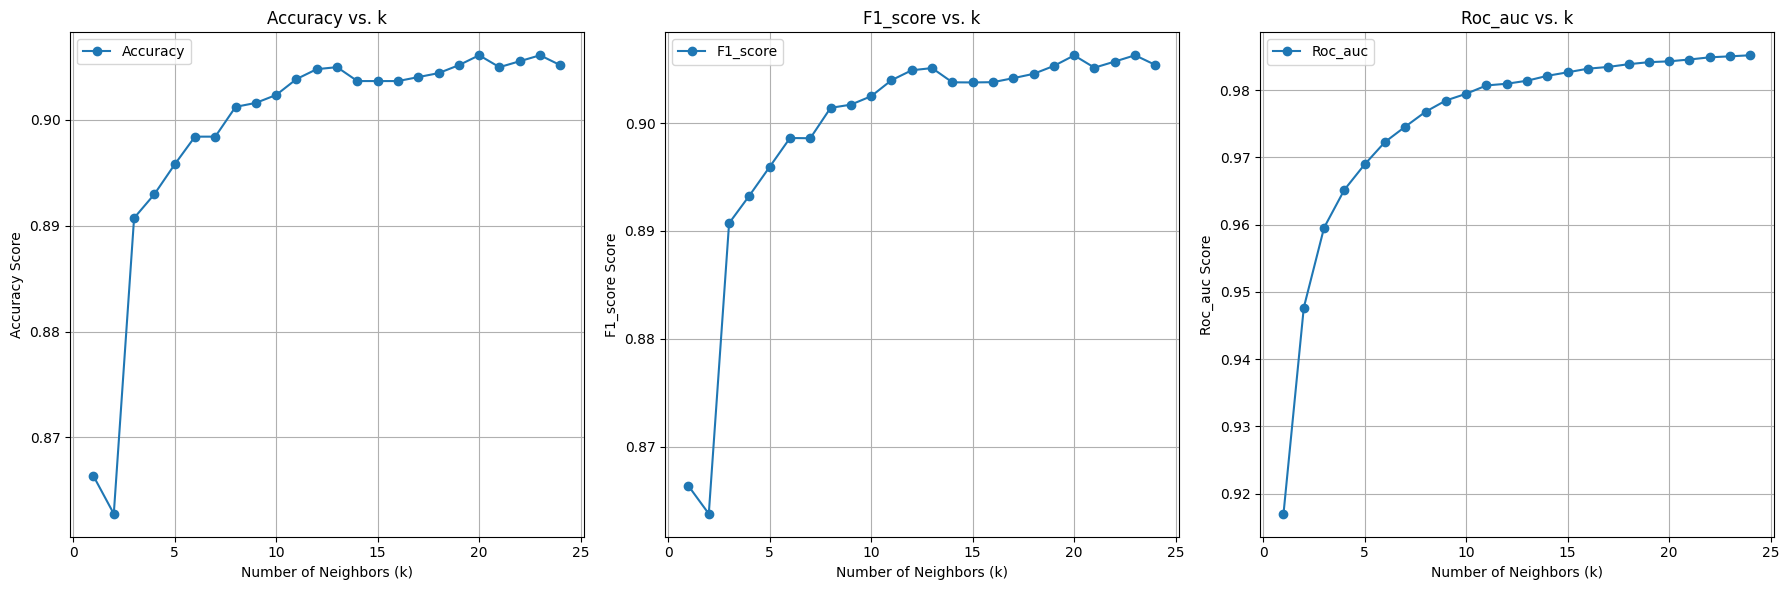

In [3]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the pipeline
pipeline = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])

# Define the parameter grid
param_grid = {"knn__n_neighbors": range(1, 25)}

# Define scoring metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1_score": make_scorer(f1_score, average="weighted"),
    "roc_auc": make_scorer(roc_auc_score, multi_class="ovr", needs_proba=True),
}

# Set up cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit="accuracy",
    cv=cv,
    verbose=3,
    n_jobs=-1,
)

# Fit the model
grid_search.fit(X_train, np.array(y_train).ravel())

# Output the results
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.4f}".format(grid_search.best_score_))

# Extract and plot results
cv_results = grid_search.cv_results_

plt.figure(figsize=(18, 6))
for idx, metric in enumerate(scoring.keys()):
    plt.subplot(1, len(scoring), idx + 1)
    metric_scores = cv_results[f"mean_test_{metric}"]
    plt.plot(range(1, 25), metric_scores, marker="o", label=f"{metric.capitalize()}")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel(f"{metric.capitalize()} Score")
    plt.title(f"{metric.capitalize()} vs. k")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

### Testing Different Metrics


/Users/anujpatel/Coding/Python/CSE 546/MachineLearningFinalProject-1/finalproject/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 3/4] END knn__metric=euclidean; accuracy: (test=0.912) f1_score: (test=0.912) roc_auc: (test=0.986) total time=   0.1s
[CV 1/4] END knn__metric=euclidean; accuracy: (test=0.905) f1_score: (test=0.905) roc_auc: (test=0.984) total time=   0.1s
[CV 4/4] END knn__metric=euclidean; accuracy: (test=0.896) f1_score: (test=0.897) roc_auc: (test=0.985) total time=   0.1s
[CV 3/4] END knn__metric=minkowski; accuracy: (test=0.912) f1_score: (test=0.912) roc_auc: (test=0.986) total time=   0.1s
[CV 2/4] END knn__metric=minkowski; accuracy: (test=0.906) f1_score: (test=0.906) roc_auc: (test=0.983) total time=   0.1s
[CV 4/4] END knn__metric=minkowski; accuracy: (test=0.896) f1_score: (test=0.897) roc_auc: (test=0.985) total time=   0.1s
[CV 1/4] END knn__metric=minkowski; accuracy: (test=0.905) f1_score: (test=0.905) roc_auc: (test=0.984) total time=   0.2s
[CV 2/4] END knn__metric=euclidean; accuracy: (test=0.906) f1_score: (test=0.90

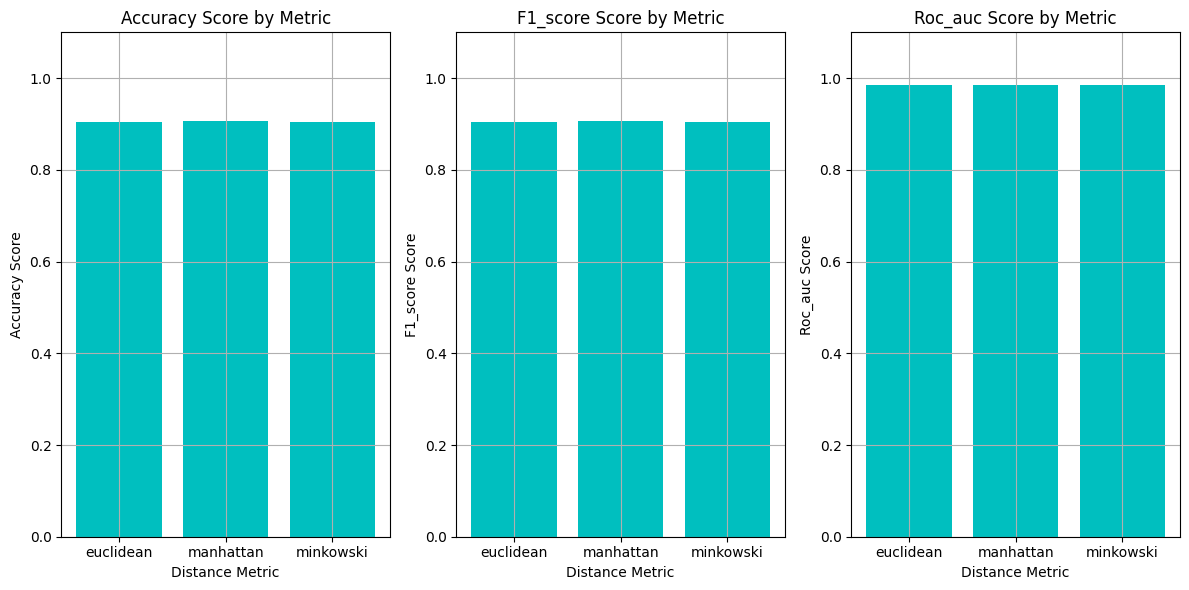

In [8]:
# Encode labels and preprocess features
le = LabelEncoder()
y = le.fit_transform(y)
X_change = pd.get_dummies(ds).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X_change, y, test_size=0.2, random_state=42
)

# Define scoring metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1_score": make_scorer(f1_score, average="weighted"),
    "roc_auc": make_scorer(roc_auc_score, multi_class="ovr", needs_proba=True),
}

# Define the pipeline
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=21)),  # `n_neighbors` is fixed to 21
    ]
)

# Define parameter grid for different distance metrics
param_grid = {"knn__metric": ["euclidean", "manhattan", "minkowski"]}

# Set up cross-validation
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit="accuracy",
    cv=cv,
    verbose=3,
    n_jobs=-1,
)

# Fit the model
grid_search.fit(X_train, y_train)

# Output the results
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.4f}".format(grid_search.best_score_))

# Extract and display results for all metrics
cv_results = grid_search.cv_results_

for metric in scoring.keys():
    best_idx = np.argmax(cv_results[f"mean_test_{metric}"])
    best_score = cv_results[f"mean_test_{metric}"][best_idx]
    print(
        f"Best {metric.capitalize()} Score: {best_score:.4f} (Metric: {cv_results['param_knn__metric'][best_idx]})"
    )

# Plot the validation scores for each metric
plt.figure(figsize=(12, 6))
for idx, metric in enumerate(scoring.keys()):
    plt.subplot(1, len(scoring), idx + 1)
    metric_scores = [
        cv_results[f"mean_test_{metric}"][i]
        for i in range(len(cv_results["param_knn__metric"]))
    ]
    plt.bar(cv_results["param_knn__metric"], metric_scores, color="c")
    plt.xlabel("Distance Metric")
    plt.ylabel(f"{metric.capitalize()} Score")
    plt.title(f"{metric.capitalize()} Score by Metric")
    plt.ylim(0.0, 1.1)
    plt.grid(True)

plt.tight_layout()
plt.show()

### Data Normalization - MinMax & Mean-Sigma & Median-MAD & RobustScaler

Running GridSearch for MinMax Scaling...
Best parameters for MinMax scaling: {'knn__n_neighbors': np.int64(33)}
Best Accuracy: 0.9068
Best F1_macro: 0.9093
Best Roc_auc_ovr: 0.9860


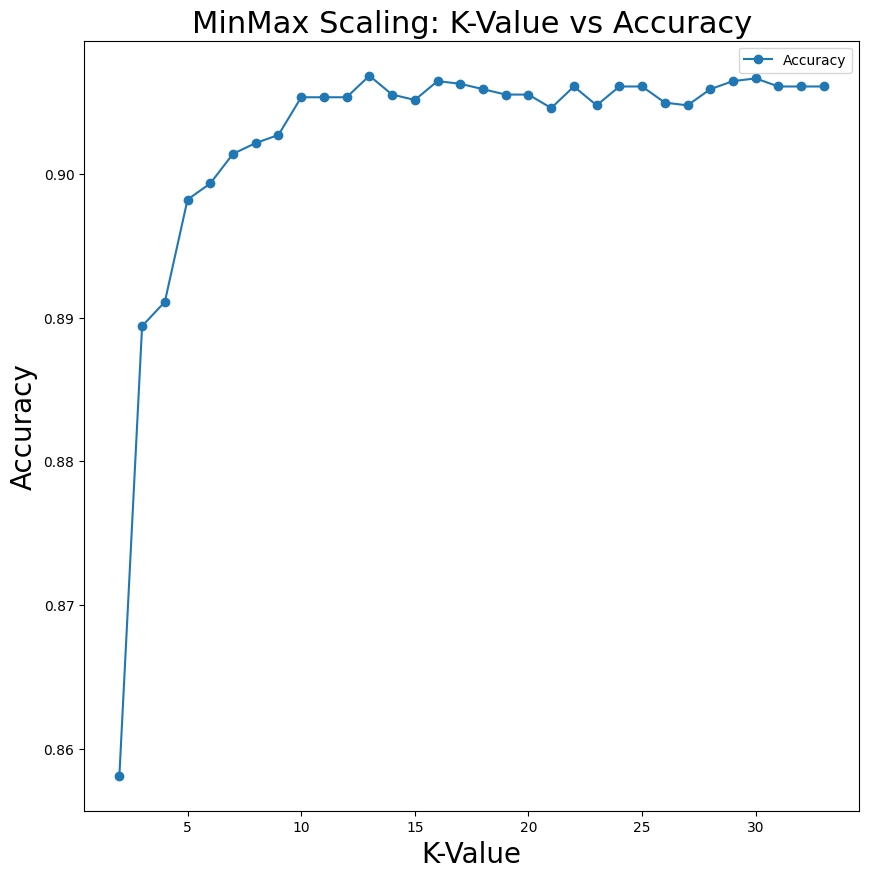

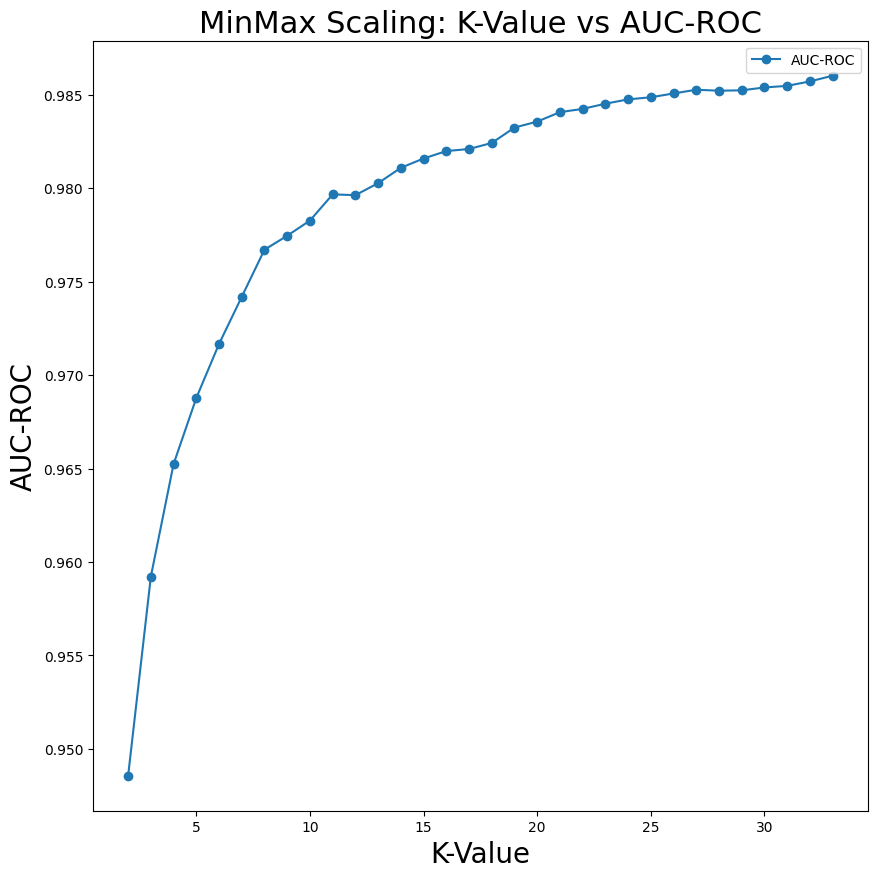

Running GridSearch for Standard Scaling...
Best parameters for Standard scaling: {'knn__n_neighbors': np.int64(33)}
Best Accuracy: 0.9074
Best F1_macro: 0.9097
Best Roc_auc_ovr: 0.9857


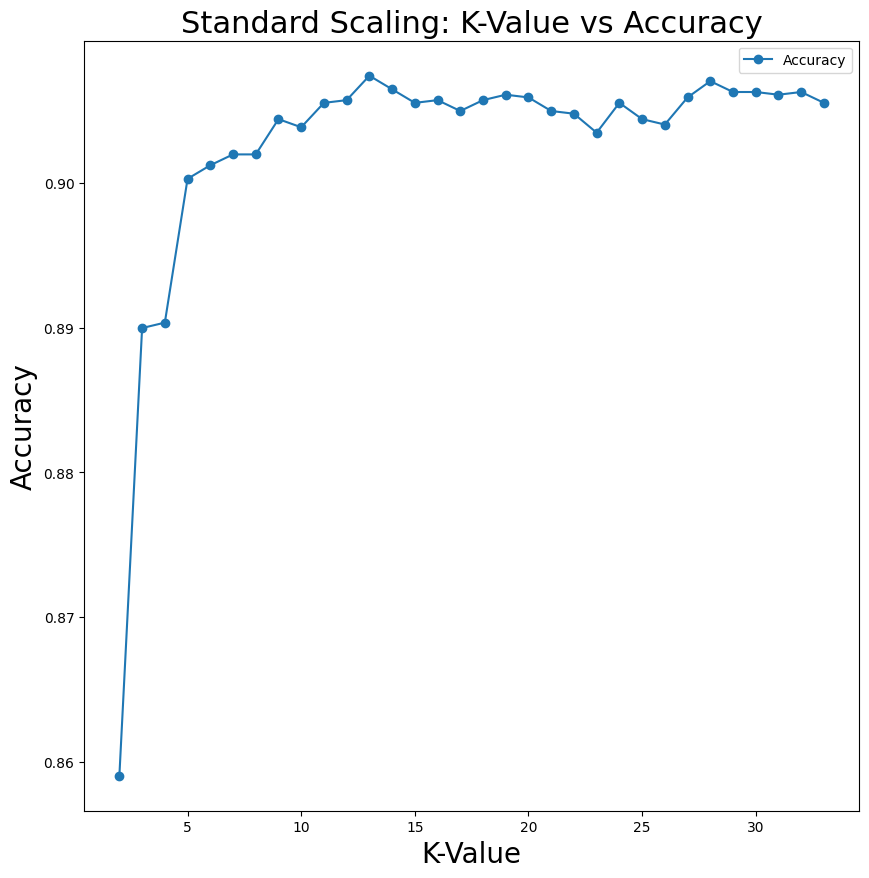

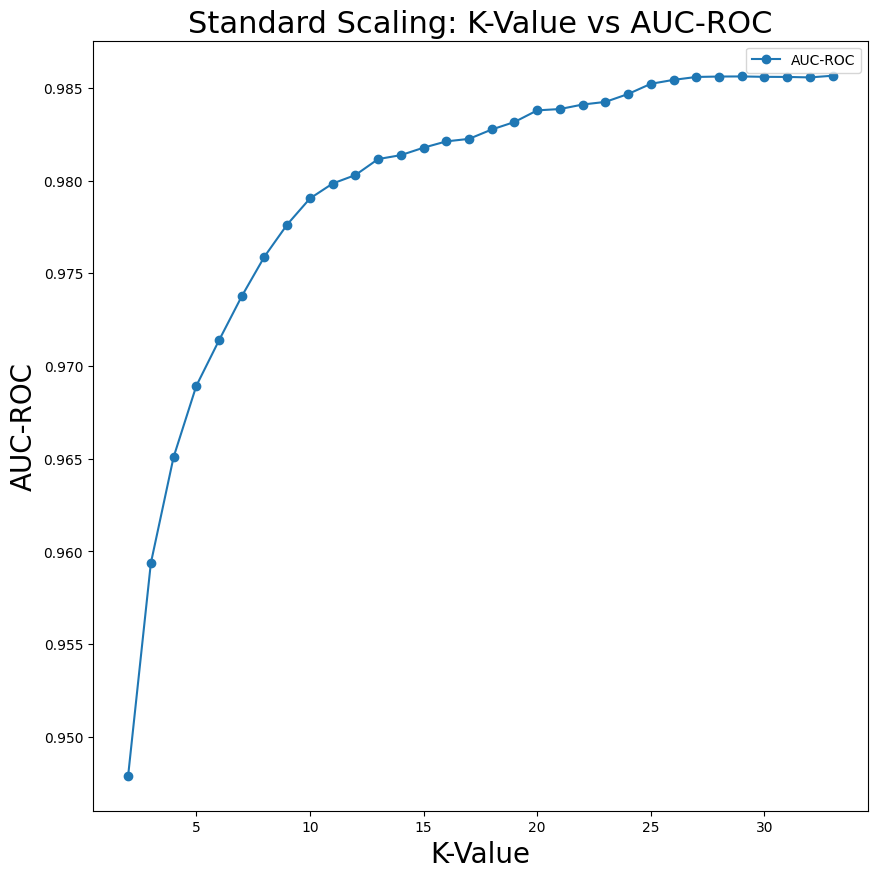

Running GridSearch for Robust Scaling...
Best parameters for Robust scaling: {'knn__n_neighbors': np.int64(33)}
Best Accuracy: 0.9059
Best F1_macro: 0.9083
Best Roc_auc_ovr: 0.9863


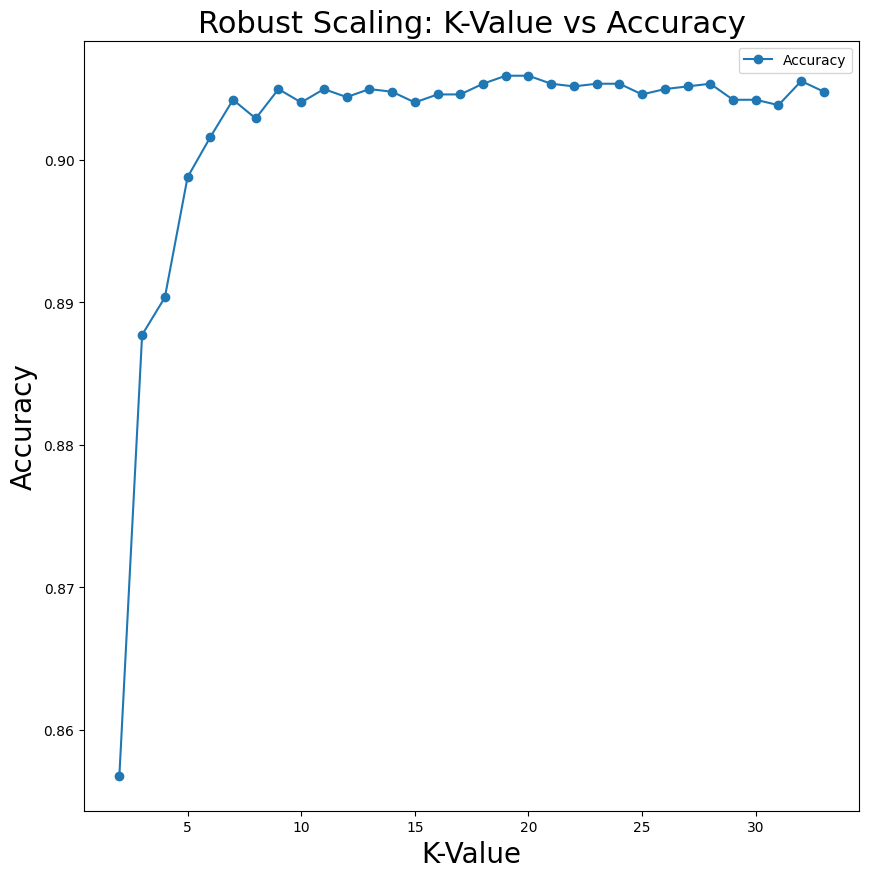

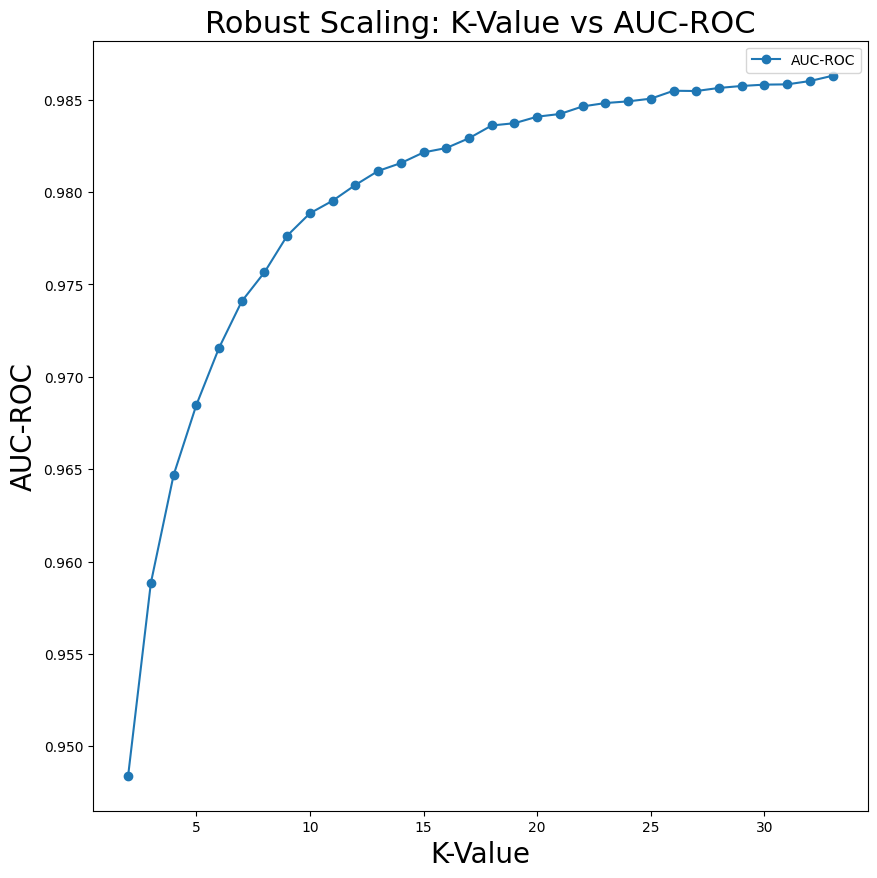

Running GridSearch for MAD Scaling...
Best parameters for MAD scaling: {'knn__n_neighbors': np.int64(33)}
Best Accuracy: 0.9063
Best F1_macro: 0.9086
Best Roc_auc_ovr: 0.9862


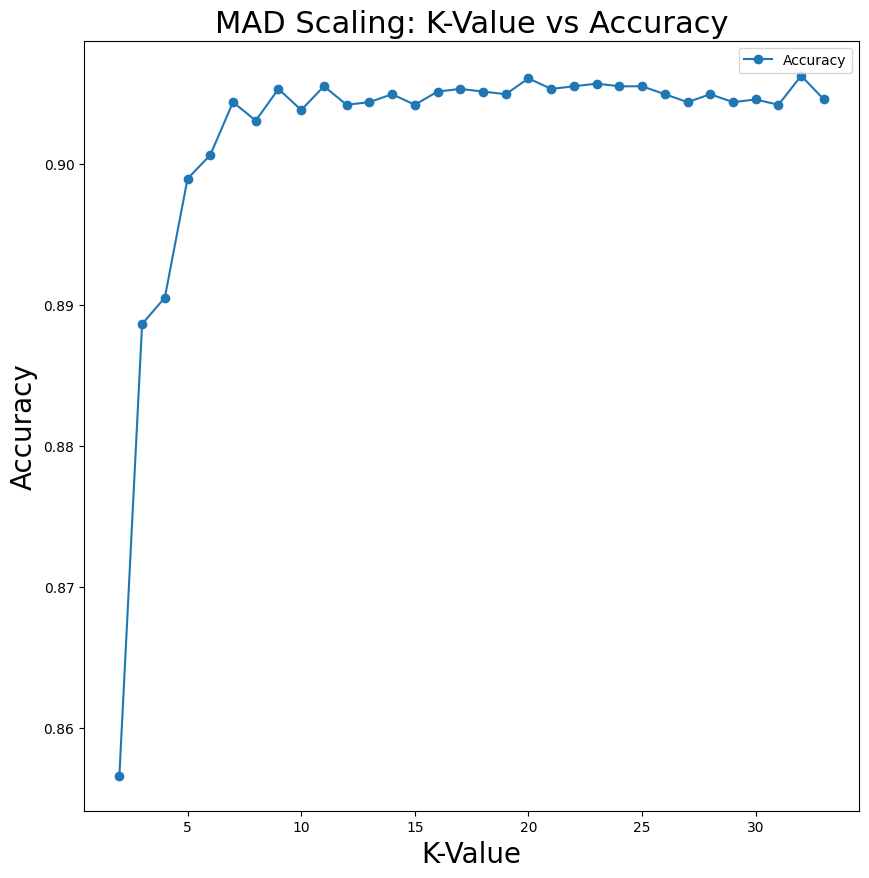

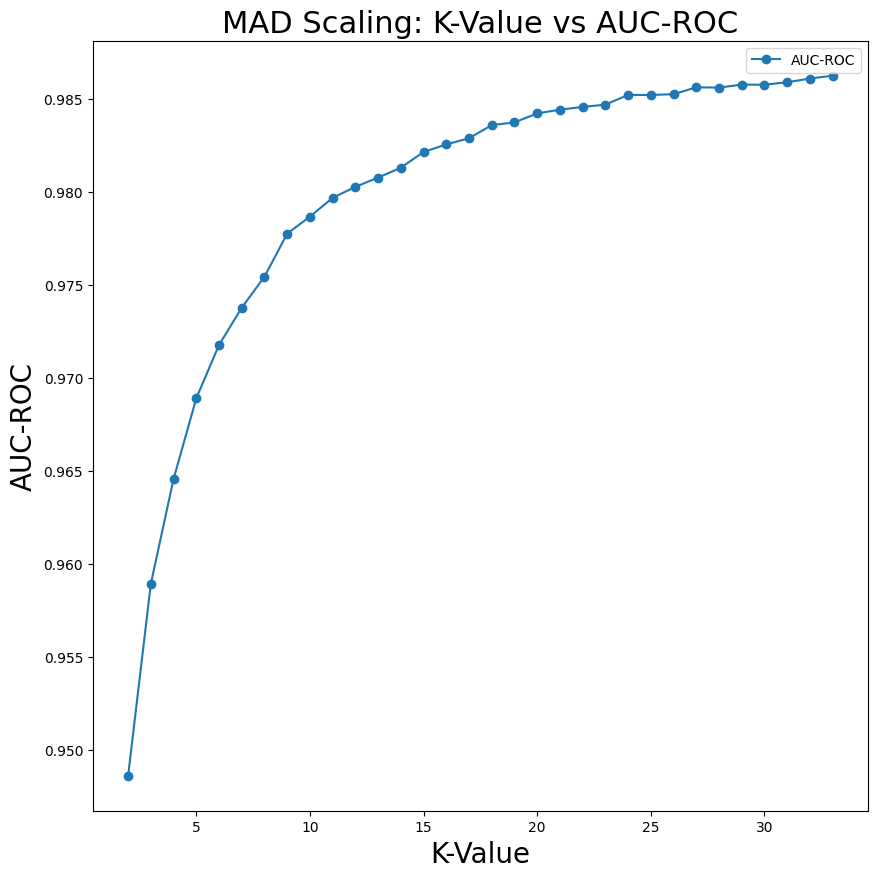

In [9]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin


class MADNormalization(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Compute the median and MAD for each feature
        self.medians_ = np.median(X, axis=0)
        self.mads_ = np.median(np.abs(X - self.medians_), axis=0)
        return self

    def transform(self, X):
        # Apply MAD normalization to each feature
        return (X - self.medians_) / self.mads_

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)


# Function to compute AUC-ROC
def compute_aucroc(model, X_test, y_test):
    y_probs = model.predict_proba(X_test)  # Get probabilities for AUC-ROC
    aucroc = roc_auc_score(y_test, y_probs, multi_class="ovr", average="weighted")
    return aucroc


# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessing methods
scalers = {
    "MinMax": MinMaxScaler(),
    "Standard": StandardScaler(),
    "Robust": RobustScaler(),
    "MAD": MADNormalization(),  # Add MAD normalization
}

# KNN Model Setup
knn = KNeighborsClassifier(metric="euclidean")

# GridSearch setup with K values
param_grid = {"knn__n_neighbors": np.arange(2, 34, 1)}

# Pipeline setup
pipeline = Pipeline(
    [("scaler", MinMaxScaler()), ("knn", knn)]  # Default to MinMax scaling initially
)

# Perform GridSearch with different scoring metrics
scoring_metrics = [
    "accuracy",
    "f1_macro",
    "roc_auc_ovr",
]

# For each scaling method
for scaler_name, scaler in scalers.items():
    print(f"Running GridSearch for {scaler_name} Scaling...")

    # Update pipeline with the current scaler
    pipeline.set_params(scaler=scaler)

    # GridSearchCV with multiple scoring metrics
    grid_search = GridSearchCV(
        pipeline, param_grid, scoring=scoring_metrics, refit="roc_auc_ovr", cv=5
    )
    grid_search.fit(X_train, y_train)

    # Get the best results
    best_params = grid_search.best_params_
    best_scores = grid_search.cv_results_

    # Output the best parameters and scores for each metric
    print(f"Best parameters for {scaler_name} scaling: {best_params}")
    for metric in scoring_metrics:
        print(
            f"Best {metric.capitalize()}: {best_scores['mean_test_' + metric][best_scores['rank_test_' + metric] == 1][0]:.4f}"
        )

    # Plot accuracy vs k-value (KNN neighbors) for the best model
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(
        best_scores["param_knn__n_neighbors"],
        best_scores["mean_test_accuracy"],
        marker="o",
        linestyle="-",
        label="Accuracy",
    )
    ax.set_xlabel("K-Value", fontsize=20)
    ax.set_ylabel("Accuracy", fontsize=20)
    ax.set_title(f"{scaler_name} Scaling: K-Value vs Accuracy", fontsize=22)
    plt.legend()
    plt.show()

    # Plot AUC-ROC vs k-value for the best model
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(
        best_scores["param_knn__n_neighbors"],
        best_scores["mean_test_roc_auc_ovr"],
        marker="o",
        linestyle="-",
        label="AUC-ROC",
    )
    ax.set_xlabel("K-Value", fontsize=20)
    ax.set_ylabel("AUC-ROC", fontsize=20)
    ax.set_title(f"{scaler_name} Scaling: K-Value vs AUC-ROC", fontsize=22)
    plt.legend()
    plt.show()

### Feature Selection

In [ ]:
# KNN Feature selection #1
fig,ax=plt.subplots(figsize=(10,10))
k_list=np.arange(55,120,1)
knn_dict={}
for i in k_list:
    selector = SelectKBest(score_func=f_classif, k=i)
    X_selected = selector.fit_transform(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    print(i)
    knn=KNeighborsClassifier(n_neighbors=21, metric='euclidean')
    model_knn=knn.fit(X_train,y_train.ravel())
    y_knn_pred=model_knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_knn_pred)
    knn_dict[i] = accuracy
best_k = max(knn_dict, key=knn_dict.get)
best_accuracy = knn_dict[best_k]
print(f"Feature Select #1: Highest Accuracy: {best_accuracy:.4f} at k={best_k}")
ax.plot(knn_dict.keys(),knn_dict.values(), marker='o', linestyle='-')
ax.set_xlabel('K-VALUE', fontsize=20)
ax.set_ylabel('Accuracy',fontsize=20)
ax.set_title('K-Value vs Accuracy', fontsize=22)
plt.show()

# KNN Feature selection #2 -  model based fs  ------------
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
selector = SelectFromModel(rf, threshold="median") #selects above the median
selector.fit(X, y)
X_selected = selector.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Feature Selection #2: Accuracy with RF-selected features: {accuracy:.4f}")
selected_features = selector.get_support(indices=True)
print(f"Feature Selection #2: Selected feature indices: {selected_features}")

In [ ]:
# KNN Feature selection #3

selector = VarianceThreshold(threshold=0)  # change threshold as needed

X_train_selected = selector.fit_transform(X_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_selected, y_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
fig,ax=plt.subplots(figsize=(10,10))
k_list=np.arange(2,34,1)
knn_dict={}
for i in k_list:
    print(i)
    knn=KNeighborsClassifier(n_neighbors=int(i), metric='euclidean')
    model_knn=knn.fit(X_train_selected,y_train.ravel())
    y_knn_pred=model_knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_knn_pred)
    knn_dict[i] = accuracy
best_k = max(knn_dict, key=knn_dict.get)
best_accuracy = knn_dict[best_k]
print(f"No preprocessing: Highest Accuracy: {best_accuracy:.4f} at k={best_k}")
ax.plot(knn_dict.keys(),knn_dict.values(), marker='o', linestyle='-')
ax.set_xlabel('K-VALUE', fontsize=20)
ax.set_ylabel('Accuracy',fontsize=20)
ax.set_title('K-Value vs Accuracy', fontsize=22)
plt.show()

## MNB Classifier

### Base Algorithm

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# MinMaxScaler inside a pipeline
scaler = MinMaxScaler()

# Define the hyperparameter grid for Multinomial Naive Bayes
param_grid = {
    "mnb__alpha": np.logspace(-4, 4, 9)  # Alpha values for MNB, range from 1e-4 to 1e4
}

# Define scoring metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "roc_auc": make_scorer(roc_auc_score, multi_class='ovr'),  # AUC-ROC for multi-class classification
    "f1": make_scorer(f1_score, average="weighted"),
}

# Set up Stratified K-Fold cross-validation
cv = KFold(n_splits=4, shuffle=True, random_state=50)

# Create the pipeline with MinMaxScaler and Multinomial Naive Bayes
pipeline = Pipeline(
    [("scaler", scaler), ("mnb", MultinomialNB())]  # Scaling step  # MNB classifier
)

# GridSearchCV for MNB with multiple scoring metrics
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit="accuracy",  # Use accuracy for model selection
    cv=cv,
    return_train_score=True,
    verbose=1,
)

# Fit the model on training data
grid_search.fit(X_train, y_train)

# Extract results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Display top results sorted by validation accuracy
top_results = results_df.sort_values(by="mean_test_accuracy", ascending=False).head(5)
print("Top 5 Hyperparameter Combinations:")
print(
    top_results[
        ["param_mnb__alpha", "mean_test_accuracy", "mean_test_f1", "mean_test_aucroc"]
    ]
)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nBest Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_score:.4f}")

# Evaluate the best model on the test set
test_accuracy = grid_search.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualization of metrics for the best alpha
metrics = [
    "mean_test_accuracy",
    "mean_test_f1",
    "mean_test_aucroc",  # Include AUC-ROC in the visualization
]
# Extracting the metric values for the best alpha value
best_alpha_values = best_results["param_mnb__alpha"].values
metrics_values = best_results[metrics].values

# Plot the results
plt.figure(figsize=(18, 6))

# Iterate over each metric and plot it separately
for idx, metric in enumerate(metrics):
    plt.plot(
        best_alpha_values,
        metrics_values[:, idx],
        marker="o",
        linestyle="-",
        label=metric,
    )

plt.title("Performance Metrics for Best Hyperparameters", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Alpha (Regularization Strength)", fontsize=12)
plt.xscale("log")  # Log scale for alpha
plt.legend()
plt.tight_layout()
plt.show()

### Data Normalization

In [ ]:
# MNB Data normalization #1: MinMax
scaler = MinMaxScaler()
X_scaled1 = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled1, y, test_size=0.2, random_state=42)
neighbors = np.arange(1, 20) 
flag = .00001
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 
alpha_values = []
for i in range(0, 19): 
    flag *= 10
    mnb = MultinomialNB(alpha=flag, fit_prior=True)
    mnb.fit(X_train, y_train)
    train_accuracy[i] = mnb.score(X_train, y_train) 
    test_accuracy[i] = mnb.score(X_test, y_test) 
    alpha_values.append(flag)
best_index = np.argmax(test_accuracy)
best_alpha = alpha_values[best_index]
best_test_acc = test_accuracy[best_index]
print(f"MinMax: Highest Test Accuracy: {best_test_acc:.4f} at Alpha = {best_alpha:.4e}")
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
plt.legend() 
plt.xlabel('run time starting with .0001 then times 10 each run') 
plt.ylabel('Accuracy') 
plt.show()

# MNB Data normalization #2: Mean-Sigma
scaler = StandardScaler()
X_scaled2 = scaler.fit_transform(X)
if (X_scaled2 < 0).any():
    X_scaled2 -= X_scaled2.min(axis=0)  #make all features non-negative
    
X_train, X_test, y_train, y_test = train_test_split(X_scaled2, y, test_size=0.2, random_state=42)
neighbors = np.arange(1, 20) 
flag = .00001
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 
alpha_values = []
for i in range(0, 19): 
    flag *= 10
    mnb = MultinomialNB(alpha=flag, fit_prior=True)
    mnb.fit(X_train, y_train)
    train_accuracy[i] = mnb.score(X_train, y_train) 
    test_accuracy[i] = mnb.score(X_test, y_test) 
    alpha_values.append(flag)
best_index = np.argmax(test_accuracy)
best_alpha = alpha_values[best_index]
best_test_acc = test_accuracy[best_index]
print(f"Mean-Sigma: Highest Test Accuracy: {best_test_acc:.4f} at Alpha = {best_alpha:.4e}")
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
plt.legend() 
plt.xlabel('run time starting with .0001 then times 10 each run') 
plt.ylabel('Accuracy') 
plt.show()

# MNB Data normalization #3: Median-MAD
def median_mad_normalize_nonnegative(data):
    medians = np.median(data, axis=0)
    mad = np.median(np.abs(data - medians), axis=0)
    mad[mad == 0] = 1  # Prevent division by zero
    normalized_data = (data - medians) / mad

    # Shift to make all values non-negative
    min_val = np.min(normalized_data)
    if min_val < 0:
        normalized_data += abs(min_val) + 1e-6  # Shift to ensure non-negativity
    return normalized_data
X_scaled3 = median_mad_normalize_nonnegative(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled3, y, test_size=0.2, random_state=42)
neighbors = np.arange(1, 20) 
flag = .00001
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 
alpha_values = []
for i in range(0, 19): 
    flag *= 10
    mnb = MultinomialNB(alpha=flag, fit_prior=True)
    mnb.fit(X_train, y_train)
    train_accuracy[i] = mnb.score(X_train, y_train) 
    test_accuracy[i] = mnb.score(X_test, y_test) 
    alpha_values.append(flag)
best_index = np.argmax(test_accuracy)
best_alpha = alpha_values[best_index]
best_test_acc = test_accuracy[best_index]
print(f"Median-MAD: Highest Test Accuracy: {best_test_acc:.4f} at Alpha = {best_alpha:.4e}")
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
plt.legend() 
plt.xlabel('run time starting with .0001 then times 10 each run') 
plt.ylabel('Accuracy') 
plt.show()

# MNB Data normalization #4: robustScaler
robust_scaler = RobustScaler()
X_scaled4 = robust_scaler.fit_transform(X)
X_scaled4 = X_scaled4 - X_scaled4.min(axis=0) #shift so no negatives

X_train, X_test, y_train, y_test = train_test_split(X_scaled4, y, test_size=0.2, random_state=42)
neighbors = np.arange(1, 20) 
flag = .00001
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 
alpha_values = []
for i in range(0, 19): 
    flag *= 10
    mnb = MultinomialNB(alpha=flag, fit_prior=True)
    mnb.fit(X_train, y_train)
    train_accuracy[i] = mnb.score(X_train, y_train) 
    test_accuracy[i] = mnb.score(X_test, y_test) 
    alpha_values.append(flag)
best_index = np.argmax(test_accuracy)
best_alpha = alpha_values[best_index]
best_test_acc = test_accuracy[best_index]
print(f"robust scaler: Highest Test Accuracy: {best_test_acc:.4f} at Alpha = {best_alpha:.4e}")
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
plt.legend() 
plt.xlabel('run time starting with .0001 then times 10 each run') 
plt.ylabel('Accuracy') 
plt.show()

### Feature Selection

In [ ]:
# MNB Feature selection #1
scaler = MinMaxScaler()
X_scaleMNBMinMax = scaler.fit_transform(X)
k = 50  # Number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_selectMNBagain = selector.fit_transform(X_scaleMNBMinMax, y)

X_train, X_test, y_train, y_test = train_test_split(X_selectMNBagain, y, test_size=0.2, random_state=42)
neighbors = np.arange(1, 20)
flag = .00001
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
alpha_values = []
for i in range(0, 19):
    flag *= 10
    mnb = MultinomialNB(alpha=flag, fit_prior=True)
    mnb.fit(X_train, y_train)
    train_accuracy[i] = mnb.score(X_train, y_train)
    test_accuracy[i] = mnb.score(X_test, y_test)
    alpha_values.append(flag)
best_index = np.argmax(test_accuracy)
best_alpha = alpha_values[best_index]
best_test_acc = test_accuracy[best_index]
print(f"MNB Feature selection 1: Highest Test Accuracy: {best_test_acc:.4f} at Alpha = {best_alpha:.4e}")
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
plt.legend()
plt.xlabel('run time starting with .0001 then times 10 each run')
plt.ylabel('Accuracy')
plt.show()

# MNB Feature selection #2 - another method found online that uses RFC
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaleMNBMinMax, y)
selector = SelectFromModel(rf, threshold="median") #selects above the median
selector.fit(X_scaleMNBMinMax, y)
X_selected = selector.transform(X_scaleMNBMinMax)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
mnb = MultinomialNB(alpha=100, fit_prior=True) #select optimal value
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with RF-selected features: {accuracy:.4f}")
selected_features = selector.get_support(indices=True)
print(f"Selected feature indices: {selected_features}")

In [ ]:
# MNB Feature selection #3
selector = VarianceThreshold(threshold=0.01)  # change threshold as needed

scaler = MinMaxScaler()
X_scaled1 = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled1, y, test_size=0.2, random_state=42)

X_train_selected = selector.fit_transform(X_train)

neighbors = np.arange(1, 20)
flag = .00001
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
alpha_values = []
for i in range(0, 19):
    flag *= 10
    mnb = MultinomialNB(alpha=flag, fit_prior=True)
    mnb.fit(X_train, y_train)
    train_accuracy[i] = mnb.score(X_train_selected, y_train)
    test_accuracy[i] = mnb.score(X_test, y_test)
    alpha_values.append(flag)
best_index = np.argmax(test_accuracy)
best_alpha = alpha_values[best_index]
best_test_acc = test_accuracy[best_index]
print(f"MNB Feature selection 1: Highest Test Accuracy: {best_test_acc:.4f} at Alpha = {best_alpha:.4e}")
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
plt.legend()
plt.xlabel('run time starting with .0001 then times 10 each run')
plt.ylabel('Accuracy')
plt.show()

## RF Classifier

### Base Algorithm

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the hyperparameter grid for Random Forest
param_grid = {
    "max_depth": [None, 5, 10, 20, 30, 50, 100],  # Max depth values to tune
    "n_estimators": [1000],  # Number of trees fixed at 1000
}

# Define scoring metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "roc_auc": make_scorer(roc_auc_score, multi_class="ovr"),  # AUC-ROC for multi-class classification
    "f1": make_scorer(f1_score, average="weighted"),
}

# Set up Stratified K-Fold cross-validation
cv = KFold(n_splits=4, shuffle=True, random_state=50)

# GridSearchCV for RandomForest with multiple scoring metrics
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring=scoring,
    refit="accuracy",  # Use accuracy for model selection
    cv=cv,
    return_train_score=True,
    verbose=1,
)

# Fit the model on training data
grid_search.fit(X_train, y_train)

# Extract results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Display top results sorted by validation accuracy
top_results = results_df.sort_values(by="mean_test_accuracy", ascending=False).head(5)
print("Top 5 Hyperparameter Combinations:")
print(
    top_results[
        ["param_max_depth", "mean_test_accuracy", "mean_test_f1", "mean_test_aucroc"]
    ]
)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nBest Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_score:.4f}")

# Evaluate the best model on the test set
test_accuracy = grid_search.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualization of metrics for the best hyperparameters
metrics = [
    "mean_test_accuracy",
    "mean_test_f1",
    "mean_test_aucroc",  # Include AUC-ROC in the visualization
]
best_results = results_df[(results_df["param_max_depth"] == best_params["max_depth"])]

plt.figure(figsize=(18, 6))
plt.plot(
    best_results["param_max_depth"],
    best_results[metrics].values.flatten(),
    marker="o",
    linestyle="-",
    color="blue",
    label="Metrics Scores",
)
plt.title("Performance Metrics for Best Hyperparameters", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Max Depth", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

### Data Normalization

In [ ]:
# Define scoring metrics
scoring_metrics = {
    "accuracy": make_scorer(accuracy_score),
    "roc_auc": make_scorer(roc_auc_score, multi_class="ovr"),
    "f1": make_scorer(f1_score, average="weighted"),
}

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5, random_state=42)

# Define preprocessors for different normalization techniques
scalers = {
    "minmax": MinMaxScaler(),
    "standard": StandardScaler(),
    "robust": RobustScaler(),
}

# Grid search parameters
param_grid = {
    "rf__max_depth": [None, 5, 10, 20, 30, 50, 100],
    "rf__n_estimators": [5, 10, 50, 100],
}

# Prepare a figure to plot all results
plt.figure(figsize=(14, 10))

# Iterate over scalers
for scaler_name, scaler in scalers.items():
    # Create a pipeline that includes preprocessing and the classifier
    pipeline = Pipeline([("scaler", scaler), ("rf", rf)])

    # Initialize GridSearchCV with the defined parameters and scoring metrics
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring=scoring_metrics,
        refit="accuracy",
        cv=5,
        return_train_score=True,
    )

    # Fit the model with GridSearch
    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearch
    best_model = grid_search.best_estimator_

    # Print the best parameters and scores
    print(f"Scaler: {scaler_name}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best Accuracy: {grid_search.best_score_:.4f}")
    print(
        f"Best test Accuracy: {accuracy_score(y_test, best_model.predict(X_test)):.4f}"
    )
    print(
        f"Best test ROC AUC: {roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr'):.4f}"
    )

    # Plot the results for each scoring metric
    results = grid_search.cv_results_

    for score_name, score_func in scoring_metrics.items():
        plt.plot(
            results["param_rf__max_depth"],
            results[f"mean_test_{score_name}"],
            label=f"{score_name} - {scaler_name}",
        )

# Customizing the plot
plt.title("GridSearchCV Results for Different Scalers and Metrics")
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

### Feature Selection, Feature Importance and Trees

In [ ]:
# RF Feature selection #1
scaler = MinMaxScaler()
X_MinMaxRF = scaler.fit_transform(X)
k = 50  # Number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_RFSelector = selector.fit_transform(X_MinMaxRF, y)
numberOfNEstimatorsRF = 1000

X_train, X_test, y_train, y_test = train_test_split(X_RFSelector, y, test_size=0.2, random_state=42)
max_depth_values = [None,5, 10, 20, 30, 50, 100]
neighbors = np.arange(1, 8)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
depth_values = []
for i in range(0, 7):
    print(max_depth_values[i])
    forest = RandomForestClassifier(n_estimators=numberOfNEstimatorsRF,max_depth=max_depth_values[i], random_state=42)
    forest.fit(X_train, y_train)
    train_accuracy[i] = forest.score(X_train, y_train)
    test_accuracy[i] = forest.score(X_test, y_test)
    depth_values.append(max_depth_values[i])
best_index = np.argmax(test_accuracy)
best_alpha = depth_values[best_index]
best_test_acc = test_accuracy[best_index]
print(f"Highest Test Accuracy: {best_test_acc:.4f} at depth = {best_alpha}")
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
plt.legend()
plt.xlabel('[None,5, 10, 20, 30, 50, 100] max_depth values')
plt.ylabel('Accuracy')
plt.show()

# RF Feature importance graph #1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lengthOfFeaturesInOrder = np.arange(1, 257)
forest = RandomForestClassifier(n_estimators=numberOfNEstimatorsRF, random_state=0)
forest.fit(X_train, y_train.ravel())
importances = forest.feature_importances_
plt.figure(figsize=(8, 4))
plt.barh(lengthOfFeaturesInOrder, importances, color='skyblue')
plt.xlabel('Random Forest Importance')
plt.title('Feature Importance - RF Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

#RF Feature importance graph #2
RF = RandomForestClassifier(n_estimators=numberOfNEstimatorsRF, max_depth=None, random_state=0)
RF.fit(X_train, y_train.ravel())
RF_feature_weights = RF.feature_importances_
feature_weights=RF_feature_weights.flatten()
# Create a DataFrame to store the features and their corresponding weights
features_df = pd.DataFrame({
    'Feature': ds.columns,
    'Weight': feature_weights
})
# Sort by the absolute value of weights to see the most important features
features_df['Absolute Weight'] = np.abs(features_df['Weight'])
features_df = features_df.sort_values(by='Absolute Weight', ascending=False)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="Feature", y="Weight", data=features_df.head(20), palette="coolwarm")
plt.title("Top 10 Features by Weight in RF Model")
plt.xlabel("Feature")
plt.ylabel("Weight")
# Rotate the x labels by 45 degrees
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plotting the RF trees(change n_estimators to 1000 for actual results)
RF = RandomForestClassifier(n_estimators=numberOfNEstimatorsRF, max_depth=5, random_state=0)
RF.fit(X_train, y_train.ravel())
plt.figure(figsize=(12, 5))
tree.plot_tree(RF.estimators_[0], filled=True)
plt.title("First Tree in Random Forest")
plt.show()

# Plot the last tree
plt.figure(figsize=(12, 5))
tree.plot_tree(RF.estimators_[-1], filled=True)
plt.title("Last Tree in Random Forest")
plt.show()

In [ ]:
# RF Feature selection #3
selector = VarianceThreshold(threshold=0.01)  # change threshold as needed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_selected = selector.fit_transform(X_train)

max_depth_values = [None,5, 10, 20, 30, 50, 100]
neighbors = np.arange(1, 8)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
depth_values = []
for i in range(0, 7):
    print(max_depth_values[i])
    forest = RandomForestClassifier(n_estimators=1000,max_depth=max_depth_values[i], random_state=42)
    forest.fit(X_train, y_train)
    train_accuracy[i] = forest.score(X_train, y_train)
    test_accuracy[i] = forest.score(X_test, y_test)
    depth_values.append(max_depth_values[i])
best_index = np.argmax(test_accuracy)
best_alpha = depth_values[best_index]
best_test_acc = test_accuracy[best_index]
print(f"Highest Test Accuracy: {best_test_acc:.4f} at depth = {best_alpha}")
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
plt.legend()
plt.xlabel('[None,5, 10, 20, 30, 50, 100] max_depth values')
plt.ylabel('Accuracy')
plt.show()

## GBC Classifier

### Base Algorithm

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the pipeline
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Optional: scale features
        ("classifier", GradientBoostingClassifier(random_state=42)),
    ]
)

# Define hyperparameter grid
param_grid = {
    "classifier__n_estimators": [1, 5, 10, 20, 50, 100, 200, 500],
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "classifier__max_depth": [3],  # Fix max_depth for simplicity
}

# Define multiple scoring metrics, including AUC-ROC
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "roc_auc": make_scorer(
        roc_auc_score, multi_class="ovr"),  # AUC-ROC for multi-class classification
    "f1": make_scorer(f1_score, average="weighted"),
}

# Perform GridSearchCV with multiple scoring
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit="accuracy",  # Use 'accuracy' as the primary metric to select the best model
    cv=4,  # 4-fold cross-validation
    verbose=2,
    n_jobs=-1,
)

# Fit the model
grid_search.fit(X_train, y_train)

# Retrieve the results
results = grid_search.cv_results_

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.4f}")

# Visualize results for accuracy vs. n_estimators
n_estimators = [
    param["classifier__n_estimators"] for param in grid_search.cv_results_["params"]
]
mean_test_accuracy = results["mean_test_accuracy"]

plt.figure(figsize=(18, 6))
plt.plot(
    n_estimators,
    mean_test_accuracy,
    marker="o",
    linestyle="-",
    color="blue",
    label="Validation Accuracy",
)
plt.xscale("log")  # Use a logarithmic scale for n_estimators
plt.xlabel("Number of Estimators (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy vs. n_estimators")
plt.ylim(0.1, 1.1)  # Set y-axis limits
plt.legend()
plt.grid(True)
plt.show()

# Access scores for all metrics
print("Detailed GridSearch Results:")
for metric in scoring.keys():
    mean_scores = results[f"mean_test_{metric}"]
    print(f"\nMetric: {metric}")
    for param, score in zip(results["params"], mean_scores):
        print(f"Params: {param}, {metric}: {score:.4f}")

### Data Normalization


In [ ]:
# Median-MAD normalization function
def median_mad_normalize(X):
    medians = np.median(X, axis=0)
    mad = np.median(np.abs(X - medians), axis=0)
    mad[mad == 0] = 1e-6  # Avoid division by zero
    return (X - medians) / mad


# Create scorers including AUC-ROC
scorers = {
    "accuracy": make_scorer(accuracy_score),
    "roc_auc": make_scorer(roc_auc_score, multi_class="ovr"),  # AUC-ROC for multi-class classification
    "f1": make_scorer(f1_score, average="weighted"),
}

# Data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# n_estimators range
n_estimators_range = [1, 5, 10, 20, 50, 100, 200, 500]

# List of preprocessing techniques
scalers = {
    "No Preprocessing": None,
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler(),
    "Median-MAD": "Median-MAD",
    "RobustScaler": RobustScaler(),
}

# To store results
results = {}

# Loop through each scaler
for scaler_name, scaler in scalers.items():
    print(f"Processing: {scaler_name}")

    # Apply Median-MAD manually if needed
    if scaler_name == "Median-MAD":
        X_train_scaled = median_mad_normalize(X_train)
        X_test_scaled = median_mad_normalize(X_test)
    elif scaler:  # Use other scalers
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:  # No preprocessing
        X_train_scaled = X_train
        X_test_scaled = X_test

    # GridSearch for GBC
    gbc = GradientBoostingClassifier(max_depth=3, learning_rate=0.1, random_state=42)
    param_grid = {"n_estimators": n_estimators_range}
    grid_search = GridSearchCV(
        gbc, param_grid, scoring=scorers, cv=5, n_jobs=-1, refit="accuracy", verbose=1
    )
    grid_search.fit(X_train_scaled, y_train.ravel())

    # Best parameters and accuracy
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(
        f"{scaler_name}: Best n_estimators = {best_params['n_estimators']}, Best Accuracy (CV) = {best_score:.4f}"
    )

    # Test set scores
    best_gbc = grid_search.best_estimator_
    test_scores = {
        scorer: grid_search.scorer_[scorer](best_gbc, X_test_scaled, y_test)
        for scorer in scorers
    }
    print(f"{scaler_name}: Test Scores: {test_scores}")

    # Save results
    results[scaler_name] = {
        "Best Params": best_params,
        "CV Scores": grid_search.cv_results_,
        "Test Scores": test_scores,
    }

    # Plot train/test accuracy over n_estimators
    train_accuracy = []
    test_accuracy = []
    for n in n_estimators_range:
        gbc = GradientBoostingClassifier(
            n_estimators=n, max_depth=3, learning_rate=0.1, random_state=42
        )
        gbc.fit(X_train_scaled, y_train.ravel())
        train_accuracy.append(gbc.score(X_train_scaled, y_train))
        test_accuracy.append(gbc.score(X_test_scaled, y_test))

    plt.plot(n_estimators_range, test_accuracy, label="Testing Accuracy", marker="o")
    plt.plot(n_estimators_range, train_accuracy, label="Training Accuracy", marker="o")
    plt.legend()
    plt.xlabel("n_estimators")
    plt.ylabel("Accuracy")
    plt.title(f"GBC Accuracy with {scaler_name}")
    plt.grid(True)
    plt.show()

# Final Results
print("\nSummary of Results:")
for scaler_name, result in results.items():
    print(f"{scaler_name}:")
    print(f"  Best Params: {result['Best Params']}")
    print(f"  Test Scores: {result['Test Scores']}")

### Feature Selection, Feature Importance and Trees

In [ ]:
# GBC Feature selection #1
scaler = MinMaxScaler()
X_scalerMinMaxGBC = scaler.fit_transform(X)
k = 50  # Number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)
XSelectorGBC = selector.fit_transform(X_scalerMinMaxGBC, y)

X_train, X_test, y_train, y_test = train_test_split(XSelectorGBC, y, test_size=0.2, random_state=42)
n_range = [1, 5, 10, 20, 50, 100, 200, 500]
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
for i in range(0, 8):
    print(n_range[i])
    gbc = GradientBoostingClassifier(n_estimators=(n_range[i]), max_depth=3, learning_rate=0.1, random_state=42)
    gbc.fit(X_train, y_train.ravel())
    train_accuracy[i] = gbc.score(X_train, y_train)
    test_accuracy[i] = gbc.score(X_test, y_test)
best_index = np.argmax(test_accuracy)
best_alpha = depth_values[best_index]
best_test_acc = test_accuracy[best_index]
print(f"GBC Feature selection 1: Highest Test Accuracy: {best_test_acc:.4f} at depth = {best_alpha}")
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
plt.legend()
plt.xlabel('[1, 5, 10, 20, 50, 100, 200, 1000] n_estimator values')
plt.ylabel('Accuracy')
plt.show()

# GBC feature selection #2
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
selector = SelectFromModel(rf, threshold="median") #selects above the median
selector.fit(X, y)
X_selected = selector.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=500, max_depth=3, learning_rate=0.1, random_state=42)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with RF-selected features: {accuracy:.4f}")
selected_features = selector.get_support(indices=True)
print(f"Selected feature indices: {selected_features}")

# GBC Feature importance #1
lengthOfFeaturesInOrder = np.arange(1, 257)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=500, max_depth=3, learning_rate=0.1, random_state=42)
gbc.fit(X_train, y_train)
importances = gbc.feature_importances_
plt.figure(figsize=(8, 4))
plt.barh(lengthOfFeaturesInOrder, importances, color='skyblue')
plt.xlabel('GradientBoostingClassifier Importance')
plt.title('Feature Importance - GBC Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

# GBC Feature importance #2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=500, max_depth=3, learning_rate=0.1, random_state=42)
gbc.fit(X_train, y_train)
RF_feature_weights = gbc.feature_importances_
feature_weights=RF_feature_weights.flatten()
# Create a DataFrame to store the features and their corresponding weights
features_df = pd.DataFrame({
    'Feature': ds.columns,
    'Weight': feature_weights
})
# Sort by the absolute value of weights to see the most important features
features_df['Absolute Weight'] = np.abs(features_df['Weight'])
features_df = features_df.sort_values(by='Absolute Weight', ascending=False)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="Feature", y="Weight", data=features_df.head(20), palette="coolwarm")
plt.title("Top 10 Features by Weight in RF Model")
plt.xlabel("Feature")
plt.ylabel("Weight")
# Rotate the x labels by 45 degrees
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plotting trees from GBC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=500, max_depth=3, learning_rate=0.1, random_state=42)
gbc.fit(X_train, y_train)

plt.figure(figsize=(12, 5))
tree.plot_tree(gbc.estimators_[0,0], filled=True)
plt.title("First Tree in GBR")
plt.show()

# Plot the last tree
plt.figure(figsize=(12, 5))
tree.plot_tree(gbc.estimators_[-1,0], filled=True)
plt.title("Last Tree in GBR")
plt.show()

## SVM Classifier

### Base Algorithm

In [ ]:
# Define normalization methods
scaling_methods = {
    "No Scaling": None,
    "MinMax": MinMaxScaler(),
    "Standard": StandardScaler(),
}

# Define scoring metrics including AUC-ROC
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "roc_auc": make_scorer(roc_auc_score, multi_class="ovr"),  # AUC-ROC for multi-class classification
    "f1": make_scorer(f1_score, average="weighted"),
}

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Results container
results = []

# Iterate over scaling methods
for scale_name, scaler in scaling_methods.items():
    print(f"Evaluating Scaling Method: {scale_name}")

    # Build pipeline
    steps = []
    if scaler is not None:
        steps.append(("scaler", scaler))
    steps.append(("svc", SVC(kernel="rbf", random_state=42)))
    pipeline = Pipeline(steps)

    # GridSearchCV setup
    param_grid = {"svc__C": [0.1, 1, 10, 100], "svc__gamma": [0.001, 0.01, 0.1, 1]}
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=skf,
        scoring=scoring,
        refit="accuracy",
        n_jobs=-1,
        verbose=1,
    )

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train.ravel())

    # Extract best scores
    best_train_accuracy = grid_search.best_score_
    best_model = grid_search.best_estimator_
    test_predictions = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)

    # Store results for each scaling method
    results.append(
        {
            "Scaling Method": scale_name,
            "Best Train Accuracy": best_train_accuracy,
            "Test Accuracy": test_accuracy,
            "Best Params": grid_search.best_params_,
        }
    )

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Display results for each metric
for metric in scoring.keys():
    print(f"\nBest result for {metric}:")
    best_metric_result = results_df.sort_values(
        by=f"Best Train Accuracy", ascending=False
    ).head(1)
    print(best_metric_result)

# Display best normalization method overall
print("\nBest Normalization Method Overall:")
best_method = results_df.loc[results_df["Best Train Accuracy"].idxmax()]
print(best_method)

### Varying Parameters

In [ ]:
# Convert dataset to NumPy
# X = ds.to_numpy()
# y = y.to_numpy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the pipeline
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize features
        (
            "svm",
            SVC(kernel="rbf", probability=True),
        ),  # SVM with RBF kernel and probability estimates
    ]
)

# Define the hyperparameter grid
param_grid = {
    "svm__C": [0.1, 10, 100],  # C values
    "svm__gamma": [0.01, 0.1, 1],  # Gamma values
}

# Define scoring metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "roc_auc": make_scorer(roc_auc_score, multi_class="ovr"),  # AUC-ROC for multi-class classification
    "f1": make_scorer(f1_score, average="weighted"),
}

# Setup StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=4)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit="accuracy",  # Choose the main metric for refitting the best model
    cv=cv,
    return_train_score=True,
)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Extract results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Display the top 5 results sorted by validation accuracy
top_results = results_df.sort_values(by="mean_test_accuracy", ascending=False).head(5)
print("Top 5 Hyperparameter Combinations:")
print(
    top_results[
        [
            "param_svm__C",
            "param_svm__gamma",
            "mean_test_accuracy",
            "mean_test_f1",
            "mean_test_aucroc",
        ]
    ]
)

# Best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nBest Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_score:.4f}")

# Evaluate on test data
test_score = grid_search.score(X_test, y_test)
print(f"Test Accuracy: {test_score:.4f}")

# Visualization: Multiple Metrics for Best Hyperparameters
metrics = [
    "mean_test_accuracy",
    "mean_test_precision",
    "mean_test_recall",
    "mean_test_f1",
    "mean_test_aucroc",  # Include AUC-ROC in the visualization
]
best_results = results_df[results_df["param_svm__C"] == best_params["svm__C"]]
best_results = best_results[
    best_results["param_svm__gamma"] == best_params["svm__gamma"]
]

plt.figure(figsize=(10, 6))
plt.bar(
    metrics,
    best_results[metrics].values.flatten(),
    color=["blue", "orange", "green", "red", "purple"],  # Adding color for AUC-ROC
)
plt.title("Performance Metrics for Best Hyperparameters", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

### Degree Parameter

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the pipeline
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize the features
        (
            "svm",
            SVC(kernel="poly", probability=True),
        ),  # SVM with polynomial kernel and probability estimates
    ]
)

# Define the hyperparameter grid
param_grid = {
    "svm__C": [0.1, 10, 100],  # Regularization parameter
    "svm__gamma": [0.01, 0.1, 1],  # Kernel coefficient
    "svm__degree": [2, 3, 4],  # Degree of the polynomial kernel
}

# Define scoring metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "roc_auc": make_scorer(
        roc_auc_score, multi_class="ovr"),  # AUC-ROC for multi-class classification
    "f1": make_scorer(f1_score, average="weighted"),
}

# Set up Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=4)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit="accuracy",  # Use accuracy for selecting the best model
    cv=cv,
    return_train_score=True,
    verbose=1,
)

# Fit the model on training data
grid_search.fit(X_train, y_train)

# Extract results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Display top 5 results sorted by validation accuracy
top_results = results_df.sort_values(by="mean_test_accuracy", ascending=False).head(5)
print("Top 5 Hyperparameter Combinations:")
print(
    top_results[
        [
            "param_svm__C",
            "param_svm__gamma",
            "param_svm__degree",
            "mean_test_accuracy",
            "mean_test_f1",
            "mean_test_aucroc",
        ]
    ]
)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nBest Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_score:.4f}")

# Evaluate the best model on the test set
test_accuracy = grid_search.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualization of metrics for the best hyperparameters
metrics = [
    "mean_test_accuracy",
    "mean_test_precision",
    "mean_test_recall",
    "mean_test_f1",
    "mean_test_aucroc", 
]
best_results = results_df[
    (results_df["param_svm__C"] == best_params["svm__C"])
    & (results_df["param_svm__gamma"] == best_params["svm__gamma"])
    & (results_df["param_svm__degree"] == best_params["svm__degree"])
]

plt.figure(figsize=(10, 6))
plt.bar(
    metrics,
    best_results[metrics].values.flatten(),
    color=["blue", "orange", "green", "red", "purple"],
)
plt.title("Performance Metrics for Best Hyperparameters", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

### Probability Section Graph

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svm = SVC(kernel='rbf', probability=True, C=100)
svm.fit(X_train, y_train.ravel())

y_probMLP = svm.predict_proba(X_test)
num_classes = y_probMLP.shape[1]
plt.figure(figsize=(15, 5))
for i in range(num_classes):
    plt.subplot(1, num_classes, i + 1)
    plt.scatter(y_test, y_probMLP[:, i], alpha=0.5)
    plt.title(f'Class {i} Probability')
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Probability')
    plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.show()

## MLP Classifier

### Base Algorithm with Data Normalization

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define scaling methods
scalers = {"No Scaling": None, "MinMax": MinMaxScaler(), "Standard": StandardScaler()}

# Define the MLP pipeline
pipeline = Pipeline(
    [
        ("scaler", None),  # Placeholder for scaler
        ("mlp", MLPClassifier(max_iter=500, random_state=42)),
    ]
)

# Define hyperparameter grid
param_grid = {
    "scaler": [None, MinMaxScaler(), StandardScaler()],  # Scaling methods
    "mlp__hidden_layer_sizes": [(64,), (128,), (64, 64)],  # Hidden layer configurations
    "mlp__activation": ["relu", "tanh"],  # Activation functions
    "mlp__alpha": [0.0001, 0.001],  # Regularization parameter
    "mlp__learning_rate": ["constant", "adaptive"],  # Learning rate schedules
}

# Define scoring metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, average="macro"),
    "recall": make_scorer(recall_score, average="macro"),
    "f1": make_scorer(f1_score, average="macro"),
    "aucroc": make_scorer(roc_auc_score, multi_class="ovo", needs_proba=True),
}

# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=4)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit="accuracy",  # Use accuracy to select the best model
    cv=cv,
    verbose=2,
    return_train_score=True,
)

# Fit the model
grid_search.fit(X_train, y_train)

# Extract results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Display the best hyperparameter combination for each scoring metric
for metric in scoring.keys():
    top_results_metric = results_df.sort_values(
        by=f"mean_test_{metric}", ascending=False
    ).head(1)
    print(f"\nBest result for {metric}:")
    print(
        top_results_metric[
            [
                "param_scaler",
                "param_mlp__hidden_layer_sizes",
                "param_mlp__activation",
                "param_mlp__alpha",
                "param_mlp__learning_rate",
                f"mean_test_{metric}",
            ]
        ]
    )

# Best parameters and score (accuracy-based)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nBest Parameters (Based on Accuracy): {best_params}")
print(f"Best Validation Accuracy: {best_score:.4f}")

# Test the best model on the test set
test_accuracy = grid_search.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot validation accuracy for each scaling method
scaling_methods = ["No Scaling", "MinMaxScaler()", "StandardScaler()"]
plt.figure(figsize=(10, 6))
for scale_method in scaling_methods:
    subset = results_df[results_df["param_scaler"].astype(str) == scale_method]
    plt.plot(
        subset["param_mlp__alpha"],
        subset["mean_test_accuracy"],
        label=f"Validation Accuracy ({scale_method})",
        marker="o",
    )

# Configure plot
plt.xscale("log")  # Log scale for alpha
plt.xlabel("Alpha (Regularization Parameter)")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs. Alpha for Different Scaling Methods")
plt.legend()
plt.tight_layout()
plt.show()

### Hidden Layer Sizes

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define pipeline
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),  # Scaling using MinMaxScaler
        ("mlp", MLPClassifier(max_iter=300, random_state=42)),  # MLP Classifier
    ]
)

# Define hyperparameter grid for hidden layer sizes
layer_configs = [(1,), (2,), (3,)]  # Number of layers
node_counts = [64, 128, 256]  # Nodes per layer
hidden_layer_combinations = [
    tuple([nodes] * layers[0]) for layers in layer_configs for nodes in node_counts
]

param_grid = {
    "mlp__hidden_layer_sizes": hidden_layer_combinations,  # Configurations of hidden layers
    "mlp__activation": ["relu", "tanh"],  # Activation functions
    "mlp__alpha": [0.0001, 0.001],  # Regularization strengths
}

# Define scoring metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "roc_auc": make_scorer(roc_auc_score, multi_class="ovr"),  # AUC-ROC for multi-class classification
    "f1": make_scorer(f1_score, average="weighted"),
}

# GridSearchCV
cv = StratifiedKFold(n_splits=4)

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit="accuracy",  # Use accuracy as the primary metric for model selection
    cv=cv,
    verbose=2,
    return_train_score=True,
)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Extract results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Display best results for each scoring type
for metric in scoring.keys():
    top_results_metric = results_df.sort_values(
        by=f"mean_test_{metric}", ascending=False
    ).head(1)
    print(f"\nBest result for {metric}:")
    print(
        top_results_metric[
            [
                "param_mlp__hidden_layer_sizes",
                "param_mlp__activation",
                "param_mlp__alpha",
                f"mean_test_{metric}",
            ]
        ]
    )

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nBest Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_score:.4f}")

# Evaluate the best model on the test set
test_accuracy = grid_search.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualize results
plt.figure(figsize=(10, 6))

# Plot validation accuracy for different configurations
for activation in ["relu", "tanh"]:
    subset = results_df[results_df["param_mlp__activation"] == activation]
    plt.plot(
        subset["param_mlp__alpha"],
        subset["mean_test_accuracy"],
        label=f"Activation: {activation}",
        marker="o",
    )

# Configure plot
plt.xscale("log")  # Log scale for alpha
plt.xlabel("Alpha (Regularization Parameter)")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs. Alpha for Different Activation Functions")
plt.legend()
plt.tight_layout()
plt.show()

### Varying Parameters

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the pipeline
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Scaling features
        ("mlp", MLPClassifier(random_state=0, max_iter=300)),  # MLP Classifier
    ]
)

# Define hyperparameter grid
param_grid = {
    "mlp__solver": ["lbfgs", "adam"],  # Solvers
    "mlp__alpha": [0.1, 1, 10, 100],  # Regularization strengths
    "mlp__hidden_layer_sizes": [
        [10, 10],
        [10],
        [10, 10, 10],
    ],  # Hidden layer configurations
}

# Define scoring metrics including AUC-ROC
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "roc_auc": make_scorer(roc_auc_score, multi_class="ovr"),  # AUC-ROC for multi-class classification
    "f1": make_scorer(f1_score, average="weighted"),
}

# Set up StratifiedKFold for consistent splits
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=50)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit="accuracy",  # Use accuracy as the main metric for selecting the best model
    cv=cv,
    verbose=2,
    return_train_score=True,
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Extract results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Display top configurations based on validation accuracy
top_results = results_df.sort_values(by="mean_test_accuracy", ascending=False).head(5)
print("\nTop 5 Configurations by Validation Accuracy:")
print(
    top_results[
        [
            "param_mlp__solver",
            "param_mlp__alpha",
            "param_mlp__hidden_layer_sizes",
            "mean_test_accuracy",
        ]
    ]
)

# Display best result for each metric
for metric in scoring.keys():
    top_result_metric = results_df.sort_values(
        by=f"mean_test_{metric}", ascending=False
    ).head(1)
    print(f"\nBest result for {metric}:")
    print(
        top_result_metric[
            [
                "param_mlp__solver",
                "param_mlp__alpha",
                "param_mlp__hidden_layer_sizes",
                f"mean_test_{metric}",
            ]
        ]
    )

# Best parameters and validation accuracy
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"\nBest Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_score:.4f}")

# Test set evaluation
test_accuracy = grid_search.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualization of train and validation scores for regularization strength (alpha)
plt.figure(figsize=(12, 6))

# Filter results for specific solver to plot
for solver in ["lbfgs", "adam"]:
    subset = results_df[results_df["param_mlp__solver"] == solver]
    plt.plot(
        subset["param_mlp__alpha"],
        subset["mean_test_accuracy"],
        label=f"Solver: {solver}",
        marker="o",
    )

# Configure plot
plt.xscale("log")
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs. Alpha for Different Solvers")
plt.legend()
plt.grid(True)
plt.show()

### MLP Predicting Probability

In [ ]:
# MLP predicting pobability ----------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mlp = MLPClassifier(solver='lbfgs', random_state=0, alpha=100, hidden_layer_sizes=[10])
mlp.fit(X_train, y_train.ravel())

y_probMLP = mlp.predict_proba(X_test)
num_classes = y_probMLP.shape[1]
plt.figure(figsize=(15, 5))
for i in range(num_classes):
    plt.subplot(1, num_classes, i + 1)
    plt.scatter(y_test, y_probMLP[:, i], alpha=0.5)
    plt.title(f'Class {i} Probability')
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Probability')
    plt.ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

## SVM and MLP

In [ ]:
# SVC and MLP together:  --------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
Xtrain = scaler.fit_transform(X_train)
Xtest = scaler.transform(X_test)

mlp = MLPClassifier(solver='lbfgs', random_state=0, alpha=100, hidden_layer_sizes=[10])
mlp.fit(Xtrain, y_train.ravel())

svm = SVC(kernel='rbf', probability=True, C=100)
svm.fit(Xtrain, y_train.ravel())

proba1 = mlp.predict_proba(Xtest)[:, 1]
proba2 = svm.predict_proba(Xtest)[:, 1]

label_encoder = LabelEncoder()
y_test_numeric = label_encoder.fit_transform(y_test)

plt.scatter(proba1, proba2, c=y_test_numeric, cmap='viridis')
plt.xlabel("Model 1 Probability")
plt.ylabel("Model 2 Probability")
plt.title("Scatter Plot of Predicted Probabilities")
plt.colorbar()
plt.show()

svm_probs = svm.predict_proba(Xtest)
mlp_probs = mlp.predict_proba(Xtest)

# Scatter plots for each class
class_labels = {0: 'person', 1: 'sign', 2: 'bike', 3: 'bus', 4: 'car'}
n_classes = len(class_labels)
fig, axes = plt.subplots(1, n_classes, figsize=(15, 4))
for i, ax in enumerate(axes):
    ax.scatter(svm_probs[:, i], mlp_probs[:, i], alpha=0.5)
    ax.set_title(f'Class {class_labels[i]}')
    ax.set_xlabel('SVM Probability')
    ax.set_ylabel('MLP Probability')

plt.suptitle('SVM vs. MLP Probability Scatter Plots per Class')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Clustering

In [ ]:
clusterRange = range(2, 26)
sse = []

print("Number of Clusters (k) | SSE")
print("-" * 30)

for k in clusterRange:
    kMeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        max_iter=500,
        tol=1e-04,
        random_state=0,
    )
    kMeans.fit(X)
    sseValue = kMeans.inertia_
    sse.append(sseValue)
    print(f"{k:<20} | {sseValue:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(clusterRange, sse, marker="o")
plt.grid(True)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [ ]:
distortions = [ ]
for i in range(5, 16):
    print(i)
    km = KMeans(n_clusters=i, init='k-means++',n_init=10, max_iter=300,random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(5,16), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

In [ ]:
# Reduce dimensionality to 2D with PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(X)
num_clusters_list = [5, 6, 7]
# num_clusters_list = [8, 9, 10]
# num_clusters_list = [11, 12, 13, 14, 15]
# num_clusters_list = [14, 15]

# Create subplots
fig, axes = plt.subplots(1, len(num_clusters_list), figsize=(16, 4))
fig.suptitle("K-means Clustering with Different Number of Clusters")

# Plot each clustering result
for i, n_clusters in enumerate(num_clusters_list):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    labels = kmeans.labels_
    
    # Scatter plot of the clusters
    ax = axes[i]
    for cluster in range(n_clusters):
        cluster_points = data_2d[labels == cluster]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster + 1}')
    
    # Plot centroids
    centroids_2d = pca.transform(kmeans.cluster_centers_)
    ax.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=200, c='black', marker='X', label='Centroids')

    ax.set_title(f"{n_clusters} Clusters")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for the main title
plt.show()

In [ ]:
km = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(X)

# Calculate silhouette scores
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')

# Plot silhouette scores for each cluster
y_ax_lower, y_ax_upper = 0, 0
yticks = []

plt.figure(figsize=(8, 6))
for i, c in enumerate(cluster_labels):
    # Collect and sort silhouette scores for samples in this cluster
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    
    # Update y-axis limits for each cluster’s silhouette plot
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    
    # Update y-ticks for each cluster
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

# Plot the average silhouette score as a red dashed line
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")

# Labeling and layout adjustments
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.title("Silhouette Plot for K-means Clustering with 5 Clusters")
plt.tight_layout()
plt.show()

In [ ]:
for idx in range(5,16):
    km = KMeans(n_clusters=idx, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)
    ari = adjusted_rand_score(y.ravel(), y_km)
    print(f"Cluster: {idx}. Adjusted Rand Index: {ari}")

In [ ]:
linkage_array = ward(X)
dendrogram(linkage_array)
ax = plt.gca()
bounds = ax.get_xbound()
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")
plt.show()

In [ ]:
# Fit AgglomerativeClustering
agg_clust = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels = agg_clust.fit_predict(X)  # Use this to get the labels

# Calculate silhouette scores
silhouette_vals = silhouette_samples(X, labels, metric='euclidean')
n_clusters = len(np.unique(labels))

# Plot silhouette scores for each cluster
y_ax_lower, y_ax_upper = 0, 0
yticks = []

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    # Collect and sort silhouette scores for samples in this cluster
    c_silhouette_vals = silhouette_vals[labels == i]
    c_silhouette_vals.sort()
    
    # Update y-axis limits for each cluster’s silhouette plot
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    
    # Update y-ticks for each cluster
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

# Plot the average silhouette score as a red dashed line
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")

# Labeling and layout adjustments
plt.yticks(yticks, range(1, n_clusters + 1))
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.title("Silhouette Plot for Agglomerative Clustering with 5 Clusters")
plt.tight_layout()
plt.show()

In [ ]:
linkage_array = linkage(X[:100], method='single')
dendrogram(linkage_array)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")
plt.show()

In [ ]:
# Fit AgglomerativeClustering
agg_clust = AgglomerativeClustering(n_clusters=5, linkage='single')
labels = agg_clust.fit_predict(X)  # Use this to get the labels

# Calculate silhouette scores
silhouette_vals = silhouette_samples(X, labels, metric='euclidean')
n_clusters = len(np.unique(labels))

# Plot silhouette scores for each cluster
y_ax_lower, y_ax_upper = 0, 0
yticks = []

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    # Collect and sort silhouette scores for samples in this cluster
    c_silhouette_vals = silhouette_vals[labels == i]
    c_silhouette_vals.sort()
    
    # Update y-axis limits for each cluster’s silhouette plot
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    
    # Update y-ticks for each cluster
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

# Plot the average silhouette score as a red dashed line
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")

# Labeling and layout adjustments
plt.yticks(yticks, range(1, n_clusters + 1))
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.title("Silhouette Plot for Agglomerative Clustering with 5 Clusters")
plt.tight_layout()
plt.show()

In [ ]:
linkage_array = linkage(X, method='complete')
dendrogram(linkage_array)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")
plt.show()

#---------------------------- SIL PART THREE

# Fit AgglomerativeClustering
agg_clust = AgglomerativeClustering(n_clusters=5, linkage='complete')
labels = agg_clust.fit_predict(X)  # Use this to get the labels

# Calculate silhouette scores
silhouette_vals = silhouette_samples(X, labels, metric='euclidean')
n_clusters = len(np.unique(labels))

# Plot silhouette scores for each cluster
y_ax_lower, y_ax_upper = 0, 0
yticks = []

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    # Collect and sort silhouette scores for samples in this cluster
    c_silhouette_vals = silhouette_vals[labels == i]
    c_silhouette_vals.sort()
    
    # Update y-axis limits for each cluster’s silhouette plot
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    
    # Update y-ticks for each cluster
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

# Plot the average silhouette score as a red dashed line
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")

# Labeling and layout adjustments
plt.yticks(yticks, range(1, n_clusters + 1))
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.title("Silhouette Plot for Agglomerative Clustering with 5 Clusters")
plt.tight_layout()
plt.show()

## Bagging

In [ ]:
#For the base classifier, we use decision tree (unpruned)
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=2000, 
                        max_samples=1.0, #draw 100% of the number of samples (with replacement) for each
                        max_features=1.0, #use 100% of the number of features (without replacement)
                        bootstrap=True, #sampling with replacement after each
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

In [ ]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

In [ ]:
# Assuming X_train is your dataset (NumPy array) and y_train is the target labels

# Step 1: Handle categorical data by encoding with LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each column of X_train
X_train_encoded = np.copy(X_train)  # Create a copy to avoid modifying the original X_train

for i in range(X_train.shape[1]):  # Iterate through each column
    if isinstance(X_train_encoded[0, i], str):  # Check if the column contains strings (categorical data)
        X_train_encoded[:, i] = label_encoder.fit_transform(X_train_encoded[:, i])

# If y_train contains categorical values, apply LabelEncoder to it too
y_train_encoded = label_encoder.fit_transform(y_train)

# Step 2: Reduce the dimensionality of X_train to 2D using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_encoded)

# Step 3: Create the meshgrid for visualization based on the reduced data
x_min = X_train_pca[:, 0].min() - 1
x_max = X_train_pca[:, 0].max() + 1
y_min = X_train_pca[:, 1].min() - 1
y_max = X_train_pca[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Step 4: Create subplots for both classifiers (Decision Tree and Bagging)
f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))

# Step 5: Train the classifiers and plot decision boundaries
for idx, clf, tt in zip([0, 1], [DecisionTreeClassifier(), BaggingClassifier()], ['Decision tree', 'Bagging']):
    clf.fit(X_train_pca, y_train_encoded)  # Fit on the 2D PCA data

    # Predict on the meshgrid and reshape to match the grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour for decision boundary
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)

    # Scatter the data points
    axarr[idx].scatter(X_train_pca[y_train_encoded == 0, 0],
                       X_train_pca[y_train_encoded == 0, 1],
                       c='blue', marker='^', label='Class 0')
    axarr[idx].scatter(X_train_pca[y_train_encoded == 1, 0],
                       X_train_pca[y_train_encoded == 1, 1],
                       c='green', marker='o', label='Class 1')

    axarr[idx].set_title(tt)
    axarr[idx].legend()

# Add labels and adjust layout
axarr[0].set_ylabel('PC 2', fontsize=12)  # Principal Component 2
plt.tight_layout()
plt.text(0, -0.2,
         s='2D Projection of 256 Features',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

plt.show()


## ADA Boosting

In [ ]:
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=10,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=100, 
                         learning_rate=0.1, #shrinks the contribution of each classifier
                         random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

In [ ]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

In [ ]:
# Assume X (256 features) and y (target) are already loaded
# For example:
# X = np.random.rand(100, 256)  # Replace with your actual data
# y = np.random.randint(0, 2, 100)  # Replace with your actual target

label_encoder = LabelEncoder()

# Apply label encoding to each column of X_train
X_train_encoded = np.copy(X_train)  # Create a copy to avoid modifying the original X_train

for i in range(X_train.shape[1]):  # Iterate through each column
    if isinstance(X_train_encoded[0, i], str):  # Check if the column contains strings (categorical data)
        X_train_encoded[:, i] = label_encoder.fit_transform(X_train_encoded[:, i])

# If y_train contains categorical values, apply LabelEncoder to it too
y_train_encoded = label_encoder.fit_transform(y_train)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded, y_train_encoded, test_size=0.2, random_state=42)

# Step 1: Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Step 2: Define classifiers (Decision Tree and AdaBoost)
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=100, learning_rate=0.5, random_state=1)

# Step 3: Create meshgrid for visualization (after PCA)
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Step 4: Create subplots for both classifiers
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))

# Step 5: Train both classifiers and visualize decision boundaries
for idx, clf, tt in zip([0, 1], [tree, ada], ['Decision tree', 'AdaBoost']):
    clf.fit(X_train_pca, y_train)  # Fit the classifier with PCA-reduced data
    
    # Predict on the meshgrid to visualize decision boundaries
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)

    # Plot the training data points
    axarr[idx].scatter(X_train_pca[y_train == 0, 0], X_train_pca[y_train == 0, 1], c='blue', marker='^', label='Class 0')
    axarr[idx].scatter(X_train_pca[y_train == 1, 0], X_train_pca[y_train == 1, 1], c='green', marker='o', label='Class 1')
    
    # Set title for each subplot
    axarr[idx].set_title(tt)
    axarr[idx].legend()

# Add labels and improve layout
axarr[0].set_ylabel('Principal Component 2', fontsize=12)
axarr[1].set_xlabel('Principal Component 1', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2, s='2D Projection of 256 Features with PCA', ha='center', va='center', fontsize=12, transform=axarr[1].transAxes)

# Show the plot
plt.show()
